In [1]:
using CSV
using DataFrames
using DifferentialEquations
using Plots; gr()

Plots.GRBackend()

In [5]:
df_p = CSV.read("outputs/20240924_grc_fits.csv", DataFrame)
df_p.Method = Symbol.(df_p.Method)
df_p

10×3 DataFrame
 Row │ Param    Val       Method 
     │ String7  Float64   Symbol 
─────┼───────────────────────────
   1 │ A₀       0.487032  Fit
   2 │ A₁       1.4512    Fit
   3 │ ψ₁       3.36539   Fit
   4 │ A₂       0.538244  Fit
   5 │ ψ₂       4.38117   Fit
   6 │ A₀       0.489592  Corr
   7 │ A₁       1.53538   Corr
   8 │ ψ₁       3.39515   Corr
   9 │ A₂       0.568273  Corr
  10 │ ψ₂       4.59739   Corr


$$
\frac{d}{dt}\phi = \omega + r\cdot f(\phi)
$$

In [3]:
function grc_model(ϕ₀, p)
    A0, A1, ψ1, A2, ψ2 = p
    @. (A0 + A1*cos(ϕ₀ - ψ1) + A2*cos(2ϕ₀ - ψ2))*2π/24
end

grc_model (generic function with 1 method)

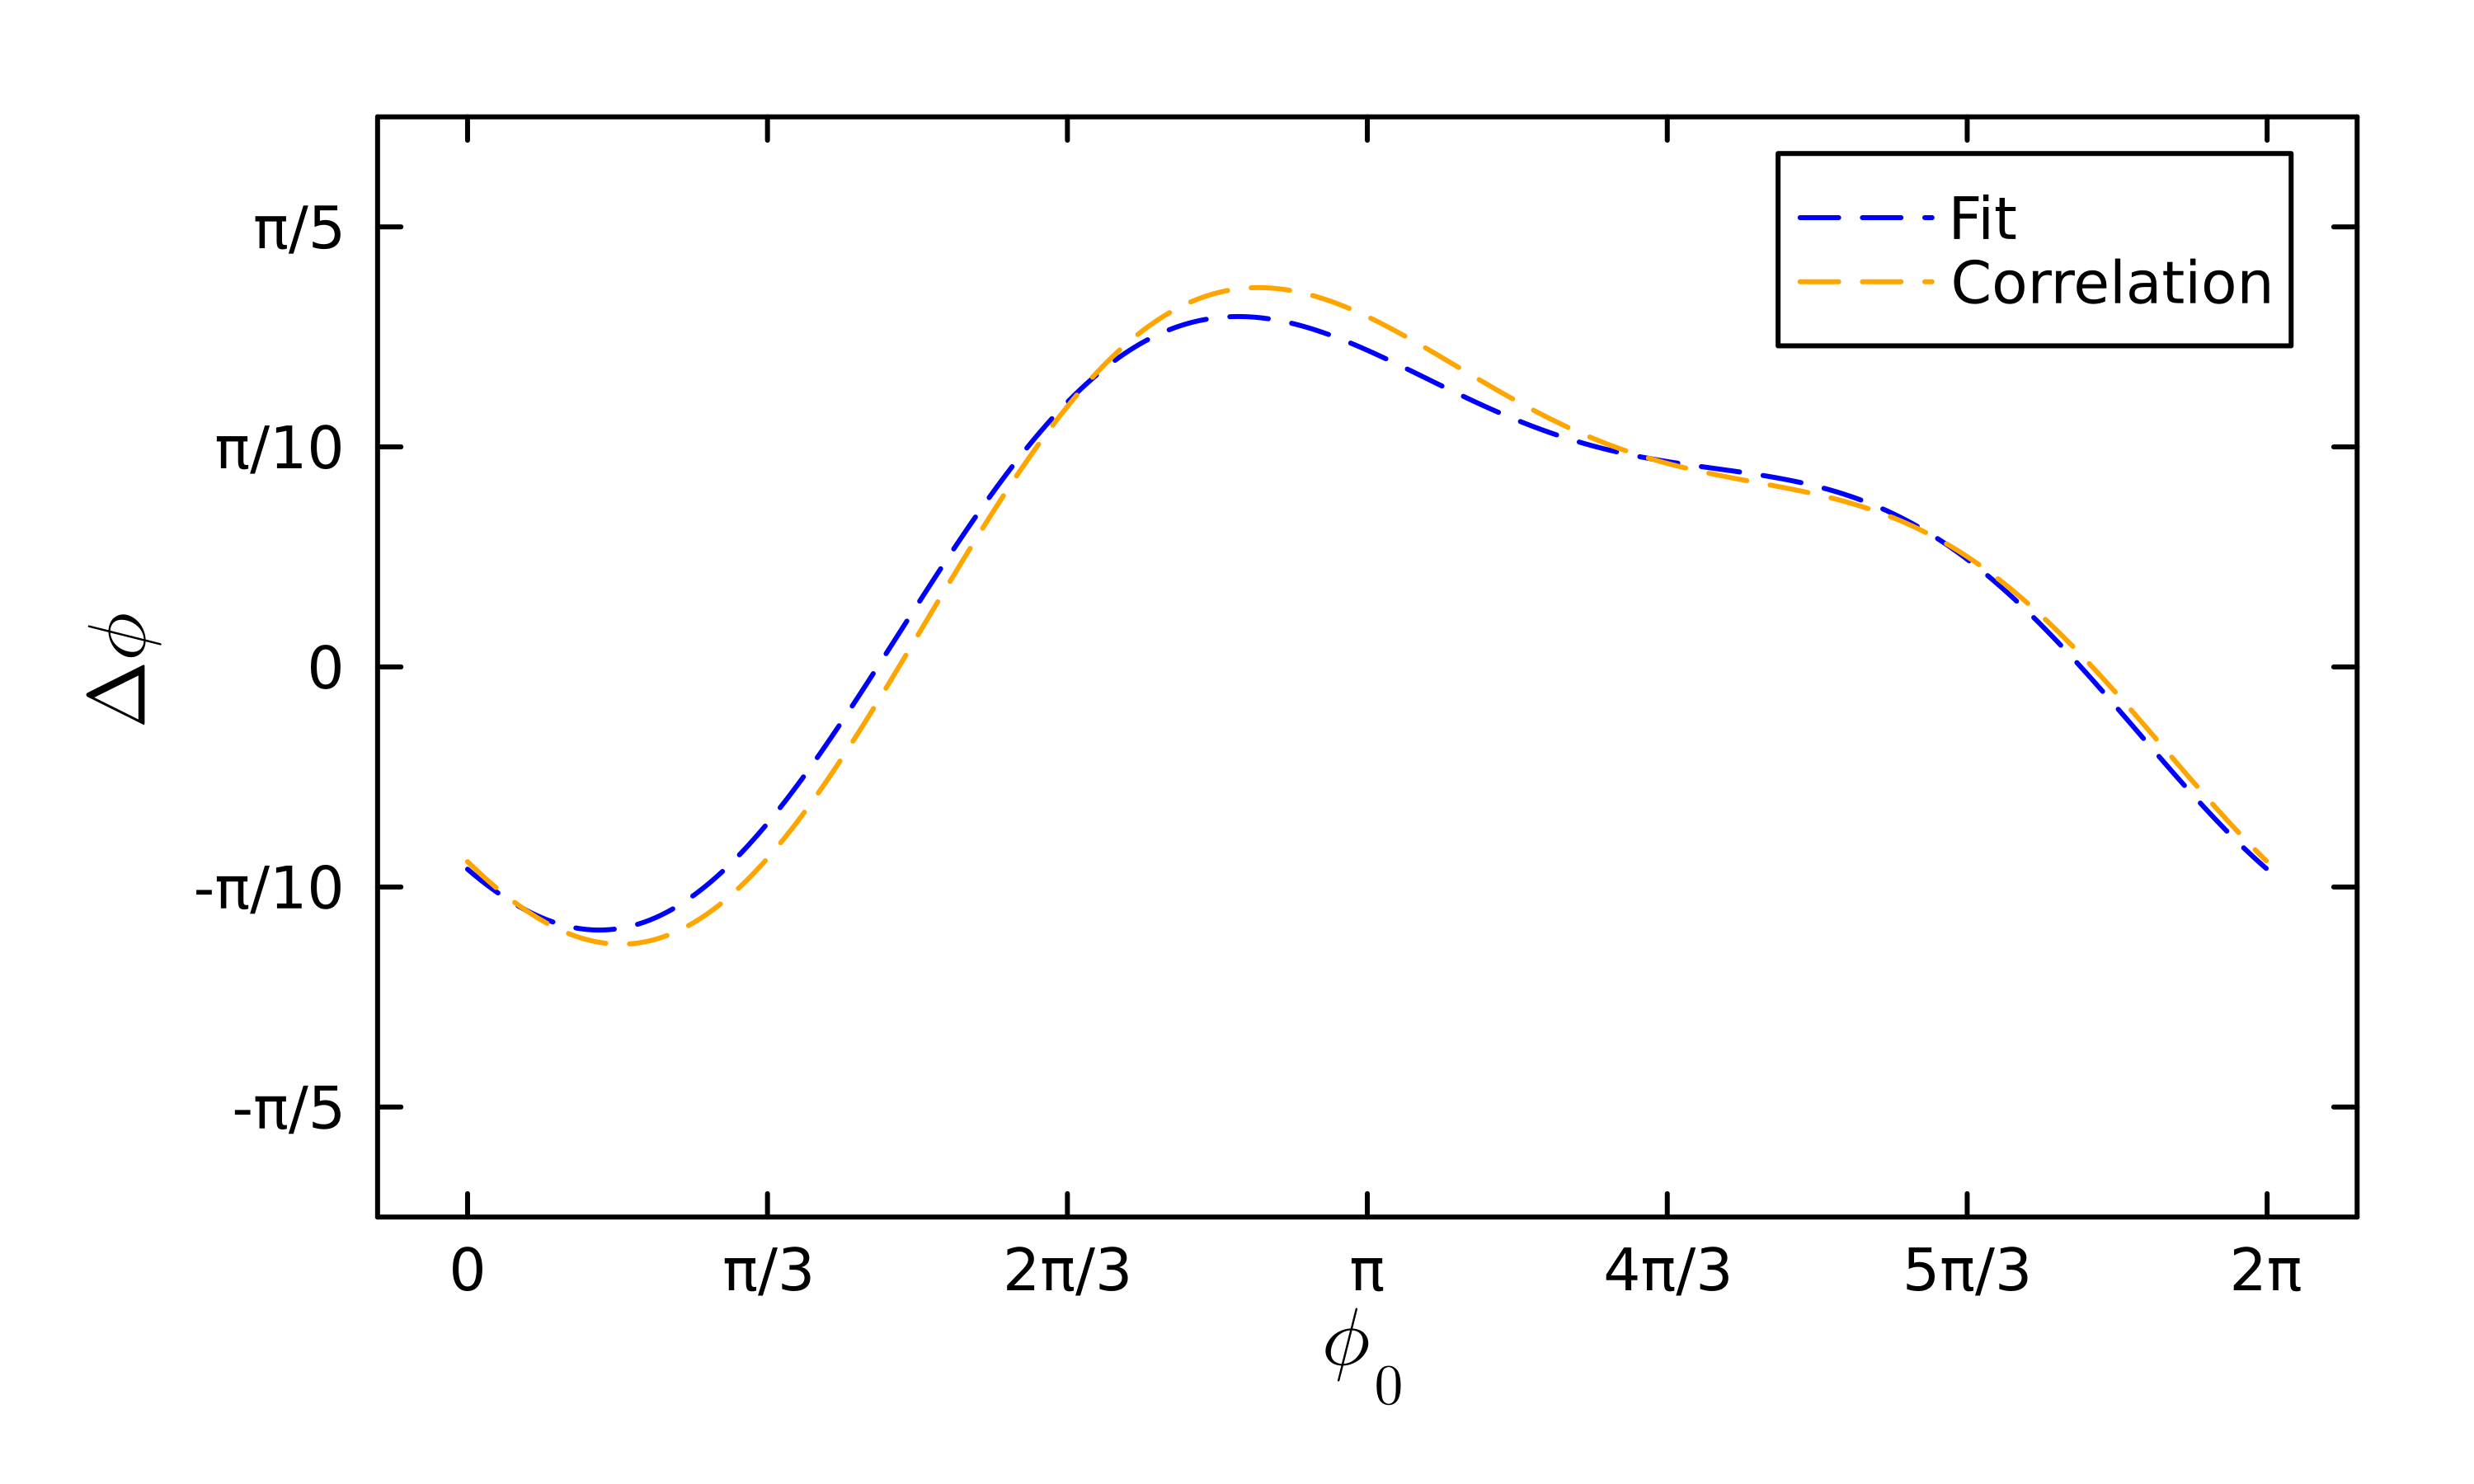

In [19]:
ϕ_span = 0:0.01:2π

plot(xlabel="\$\\phi_0\$", ylabel="\$\\Delta \\phi\$", 
    xlim=(-0.1π, 2.1π), ylim=(-π/4, π/4),
    xticks=(0:(π/3):(2π), ["0", "π/3", "2π/3", "π", "4π/3", "5π/3", "2π"]),
    yticks=(-π/5:π/10:π/5, ["-π/5", "-π/10", 0, "π/10", "π/5"]),
    frame=:box, grid=false, fmt=:png,
    size=(500, 300), dpi=600, margins=4Plots.mm)

plot!(ϕ_span, grc_model(ϕ_span, df_p[df_p.Method .== :Fit, :Val]),
    color=:blue, style=:dash, label="Fit")

plot!(ϕ_span, grc_model(ϕ_span, df_p[df_p.Method .== :Corr, :Val]),
    color=:orange, style=:dash, label="Correlation")

In [37]:
function rhs(u, p, t)
    θ = u[1]
    ω, r, f, _ = p
    dudt = [ω + r*f(θ)]
    dudt
end

rhs (generic function with 1 method)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/hSv8d/src/integrator_interface.jl:597


Doubling time = 1.0 h

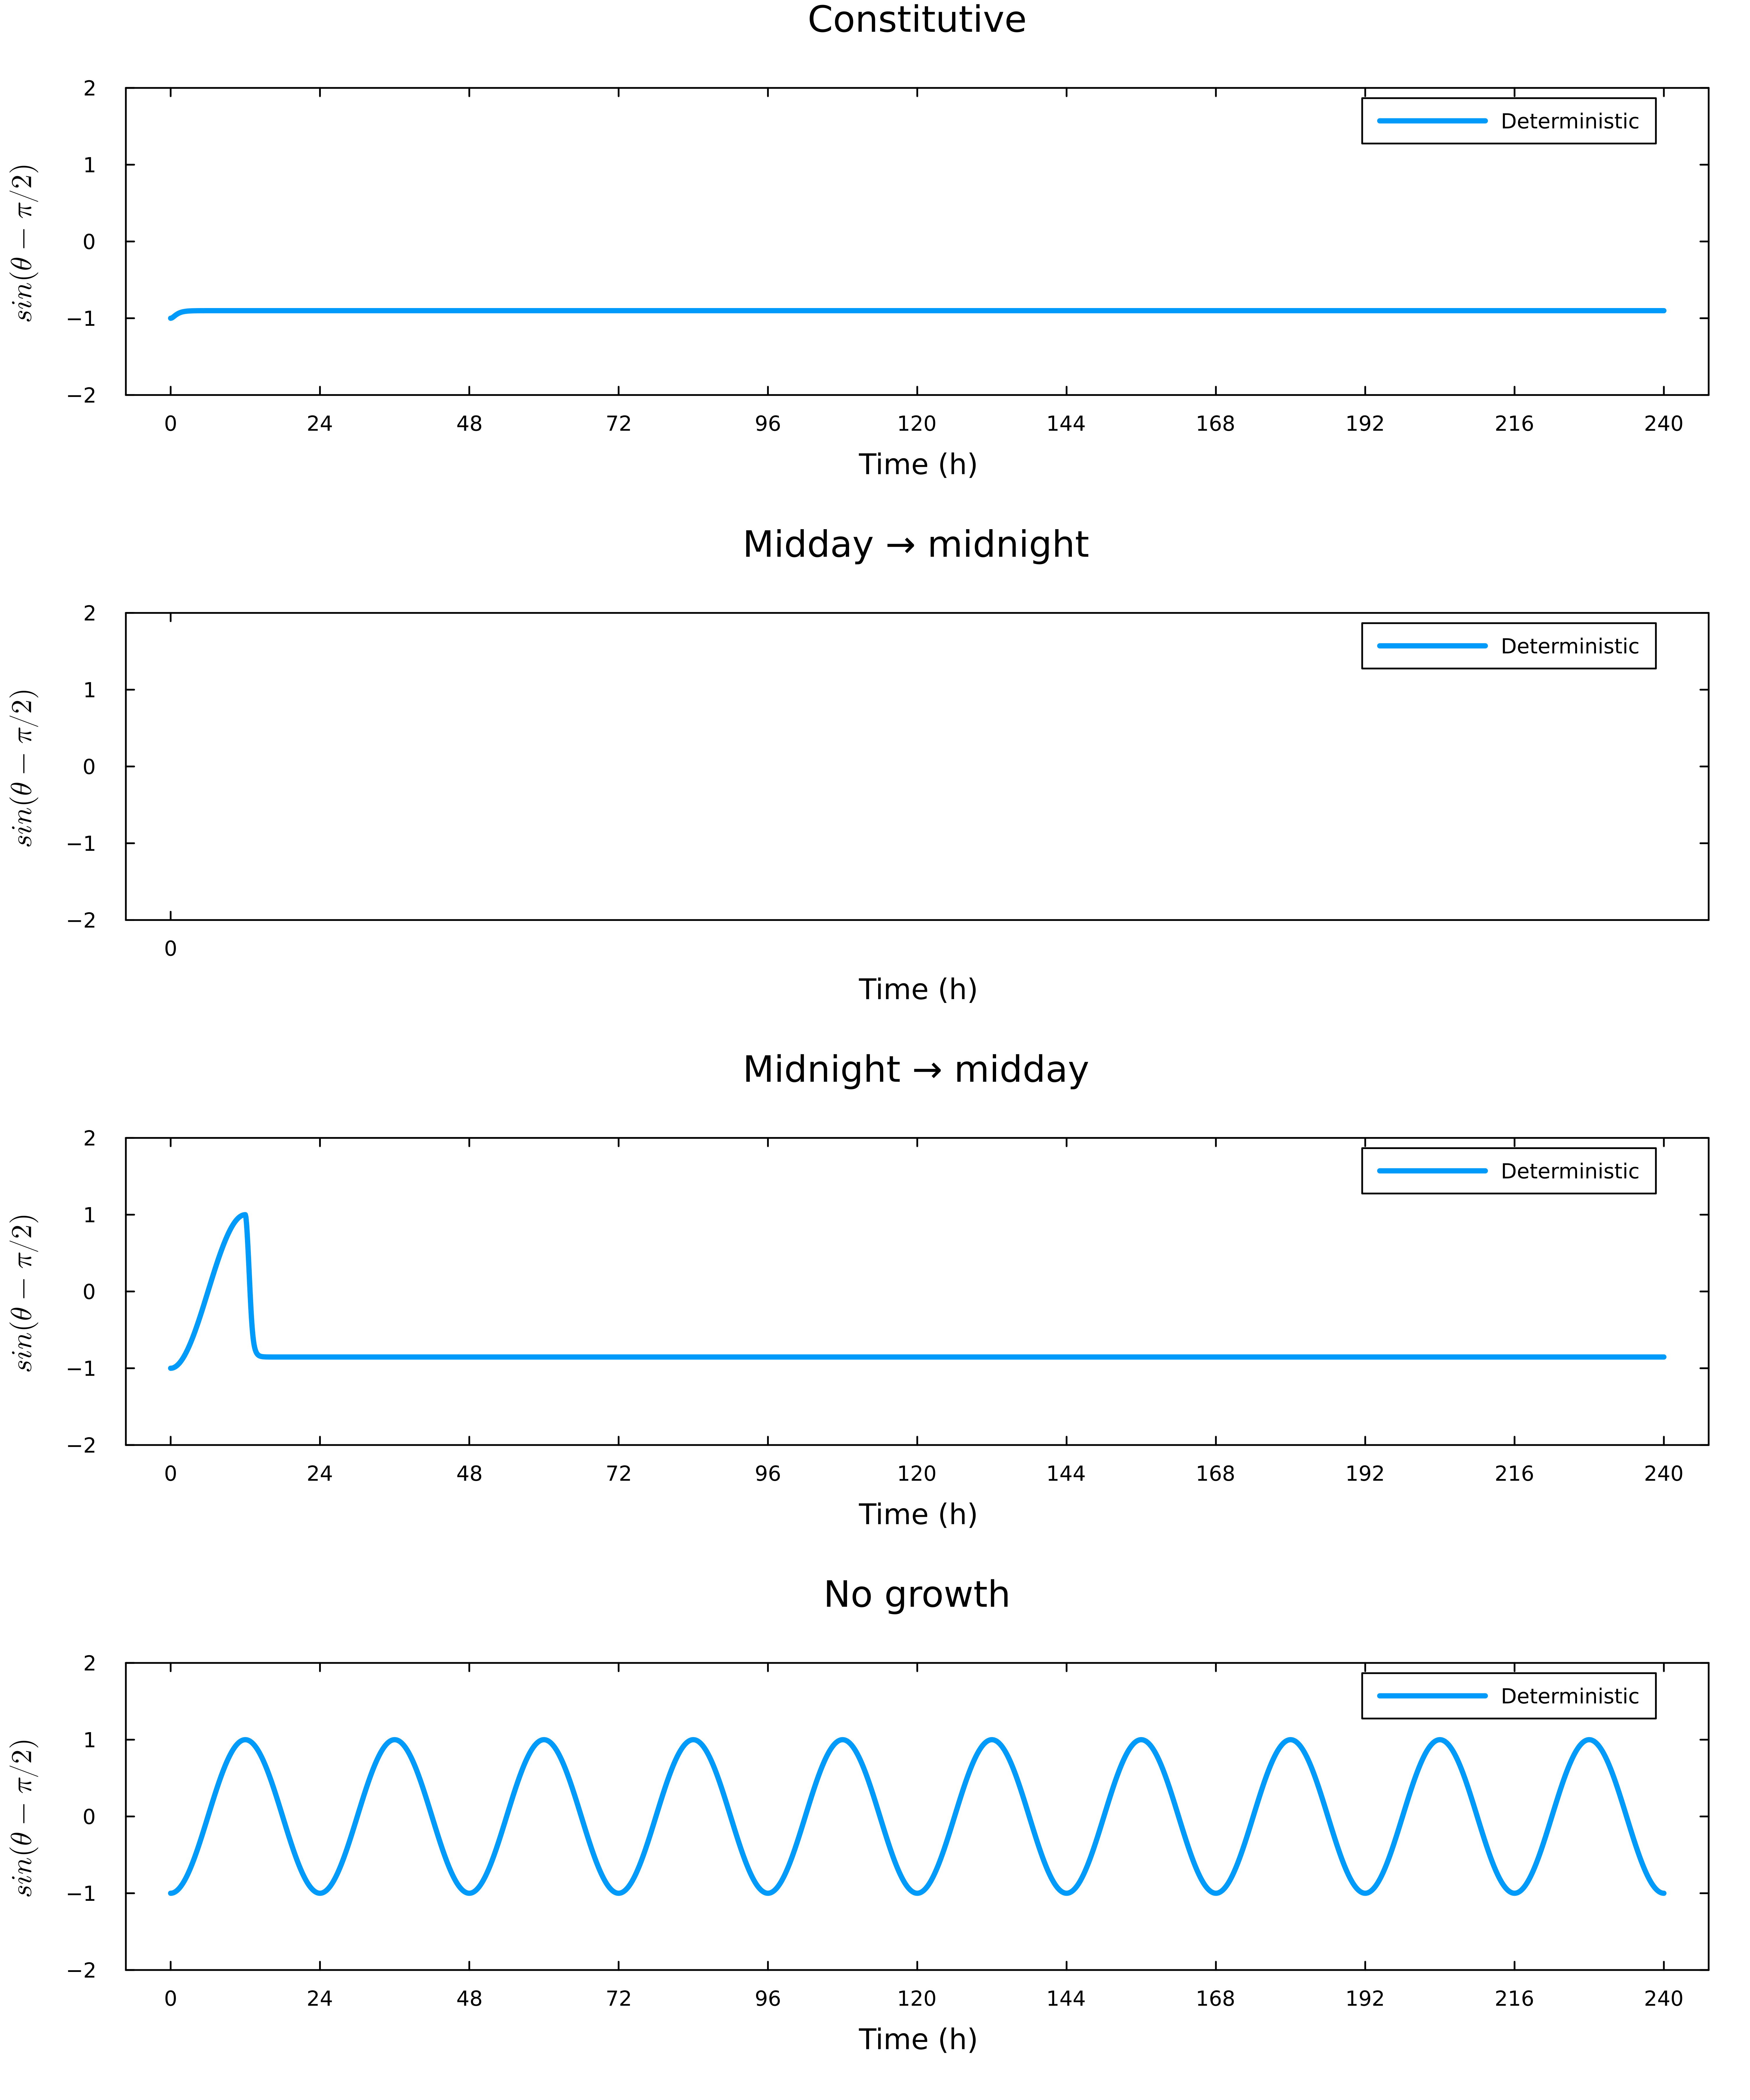

In [70]:
M= 0.25

grc_vec = (θ -> grc_model(θ, df_p[df_p.Method .== :Fit, :Val])/M,
            θ -> (x -> mod(x, 2π) < π ? 2 : 0)(θ)*grc_model(θ, df_p[df_p.Method .== :Fit, :Val])/M,
            θ -> (x -> mod(x, 2π) < π ? 0 : 2)(θ)*grc_model(θ, df_p[df_p.Method .== :Fit, :Val])/M)

plot(frame=:box, grid=false, xlabel="Time (h)", ylabel="\$sin(\\theta - \\pi/2)\$",
    ylim=(-2, 2), xticks=0:24.:240.,
    fmt=:png, size=(1000, 1200), layout=(4, 1), dpi=600, margins=4Plots.mm, legend=:best)

label_vec = ["Constitutive", "Midday → midnight", "Midnight → midday", "No growth"]

θ₀ = 0.
tspan = (0., 240.)
G = 1.

for i in 1:4
    prob = ODEProblem(rhs, [θ₀], tspan, (2π/24, log(2)/G, i < 4 ? grc_vec[i] : θ -> 0, 0.))
    sol = solve(prob, AutoTsit5(Rosenbrock23()); saveat=0.1, reltol=1e-8, abstol=1e-8)
    plot!(sol.t, sin.([u[1] for u in sol.u] .- π/2), 
        title=label_vec[i], linewidth=3, subplot=i, label="Deterministic")
end

print("Doubling time = $(G) h")
plot!()

Doubling time = 8.0 h

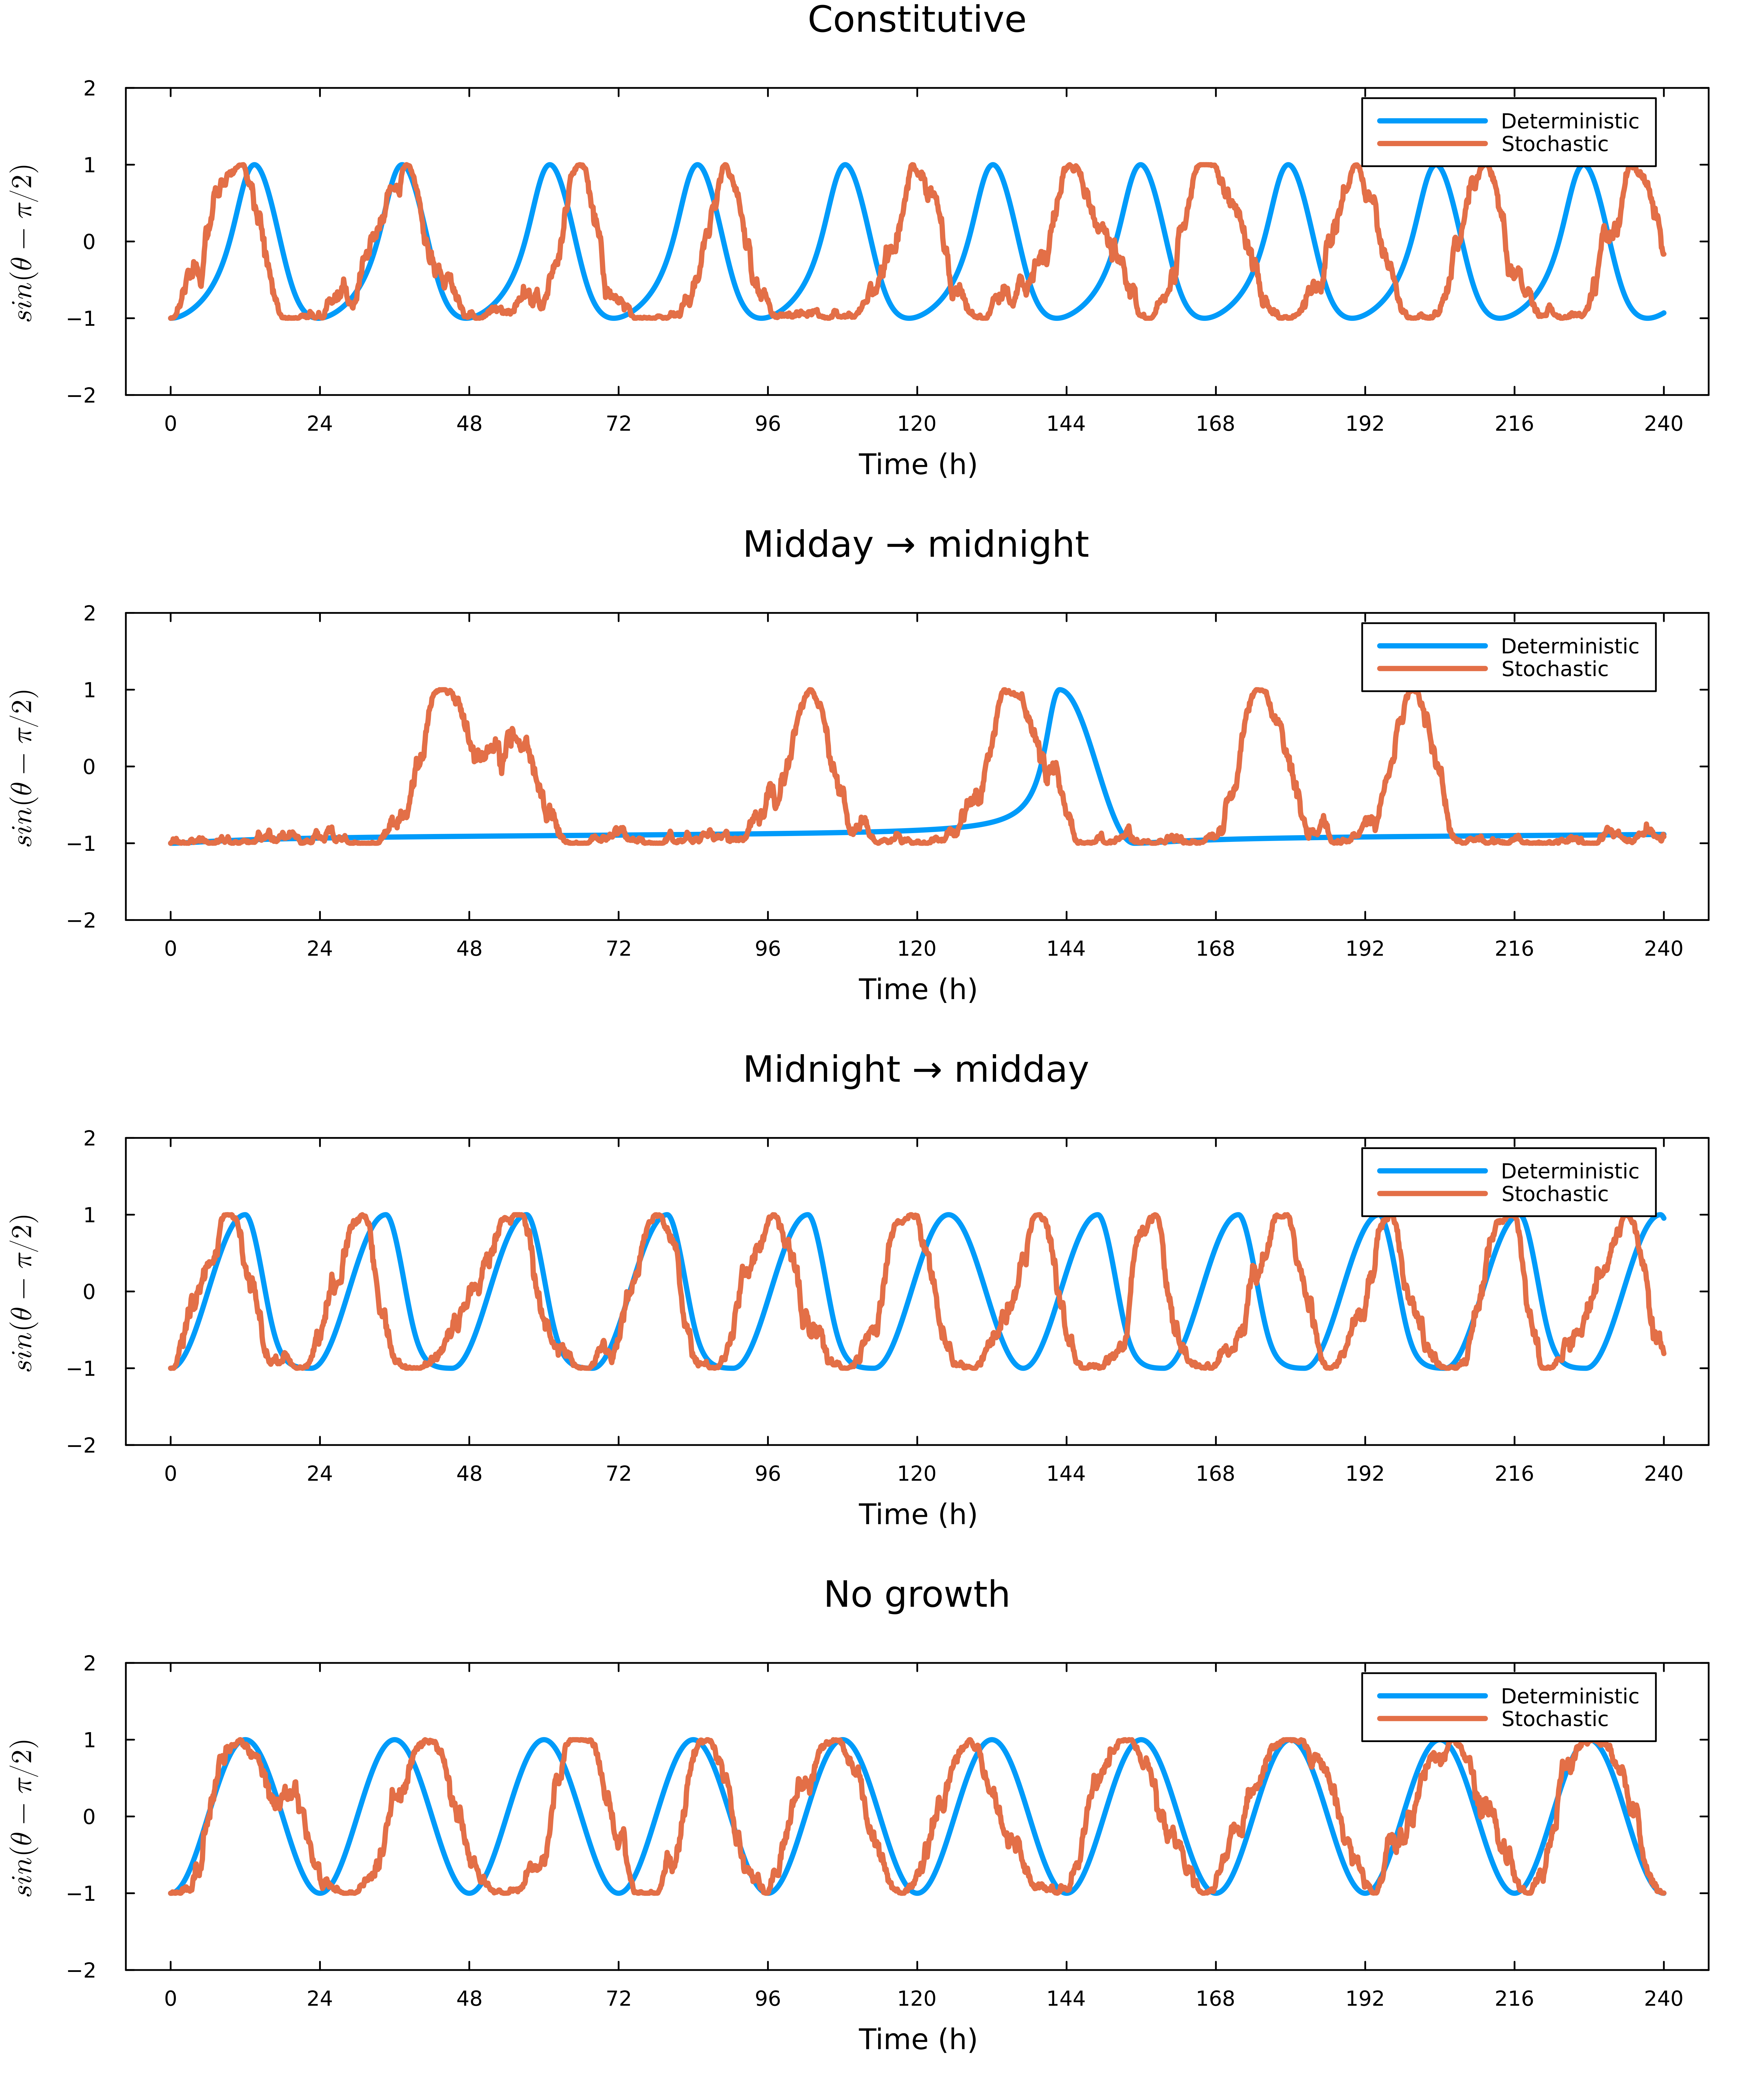

In [68]:
g = (u, p, t) -> [p[4]]
A = 0.2

for i in 1:4
    prob = SDEProblem(rhs, g, [θ₀], tspan, (2π/24, log(2)/G, i < 4 ? grc_vec[i] : θ -> 0, A))
    sol = solve(prob; saveat=0.1, reltol=1e-4, abstol=1e-4)
    plot!(sol.t, sin.([u[1] for u in sol.u] .- π/2), 
        linewidth=3, subplot=i, label="Stochastic")
end

print("Doubling time = $(G) h")
plot!()